In [ ]:
!pip install -q datasets transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
# model_checkpoint = "microsoft/swin-tiny-patch4-window7-224" # pre-trained model from which to fine-tune


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
# loading dataset

from datasets import load_dataset

ds = load_dataset("bhargob11/houseplants")

Resolving data files:   0%|          | 0/971 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/971 [00:00<?, ? examples/s]

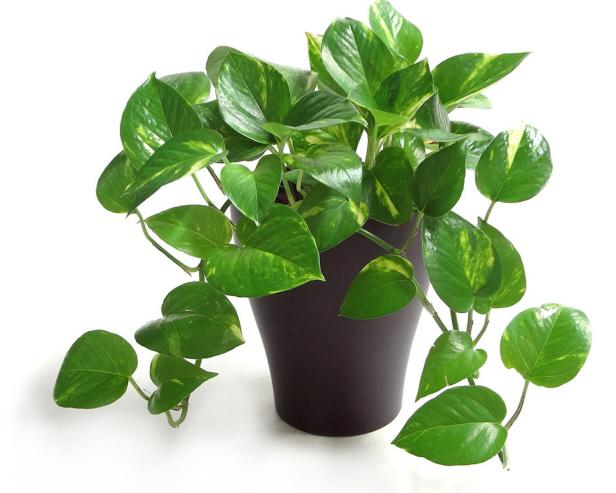

In [ ]:
# see an example

image_data = ds['train'][0]['image']

image_data
# img = Image.open(BytesIO(response.content))


In [ ]:
image_label = ds['train'][0]['label']
image_label

0

In [ ]:
label_names = ds['train'].features['label'].names

id2label, label2id = dict(), dict()
for i, label in enumerate(label_names):
    id2label[i] = label
    label2id[label] = i

id2label, label2id

id2label[0]

'healthy'

In [ ]:
# Preprocessing data
# Select a model checkpoint to fine-tune

from transformers import AutoImageProcessor

model_checkpoint = "google/vit-base-patch16-224-in21k"

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [ ]:
# train to train-val split

# split up training into training + validation
splits = ds["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

# apply transforms
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [ ]:
# downloading model checkpoint

from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
# Counting total number of trainable parameters

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

print_trainable_parameters(model)

trainable params: 85800194 || all params: 85800194 || trainable%: 100.00


In [ ]:
## Training arguments for fine-tuning
batch_size = 32

model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-housplants",
    remove_unused_columns=False,
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

<ipython-input-15-b1afd8af4f9d>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
# collate function to batch examples together

import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor, # uploading the processor to hub
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
# train the model
train_results = trainer.train()

# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


events.out.tfevents.1723701600.0ddf4ef5dd42.2650.0:   0%|          | 0.00/7.47k [00:00<?, ?B/s]

***** train metrics *****
  epoch                    =         5.0
  total_flos               = 315022221GF
  train_loss               =      0.4983
  train_runtime            =  0:02:41.55
  train_samples_per_second =      27.019
  train_steps_per_second   =       0.217


In [ ]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.8673
  eval_loss               =     0.4007
  eval_runtime            = 0:00:02.39
  eval_samples_per_second =     40.938
  eval_steps_per_second   =      1.671


In [ ]:
trainer.push_to_hub()

events.out.tfevents.1723701858.0ddf4ef5dd42.2650.1:   0%|          | 0.00/405 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/bhargob11/vit-base-patch16-224-in21k-finetuned-housplants/commit/b22057823de8124379b49a298f685f43c65a56cc', commit_message='End of training', commit_description='', oid='b22057823de8124379b49a298f685f43c65a56cc', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# Get the fine-tuned model from Hugging Face

from transformers import AutoModelForImageClassification, AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("bhargob11/vit-base-patch16-224-in21k-finetuned-housplants")
model = AutoModelForImageClassification.from_pretrained("bhargob11/vit-base-patch16-224-in21k-finetuned-housplants")

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

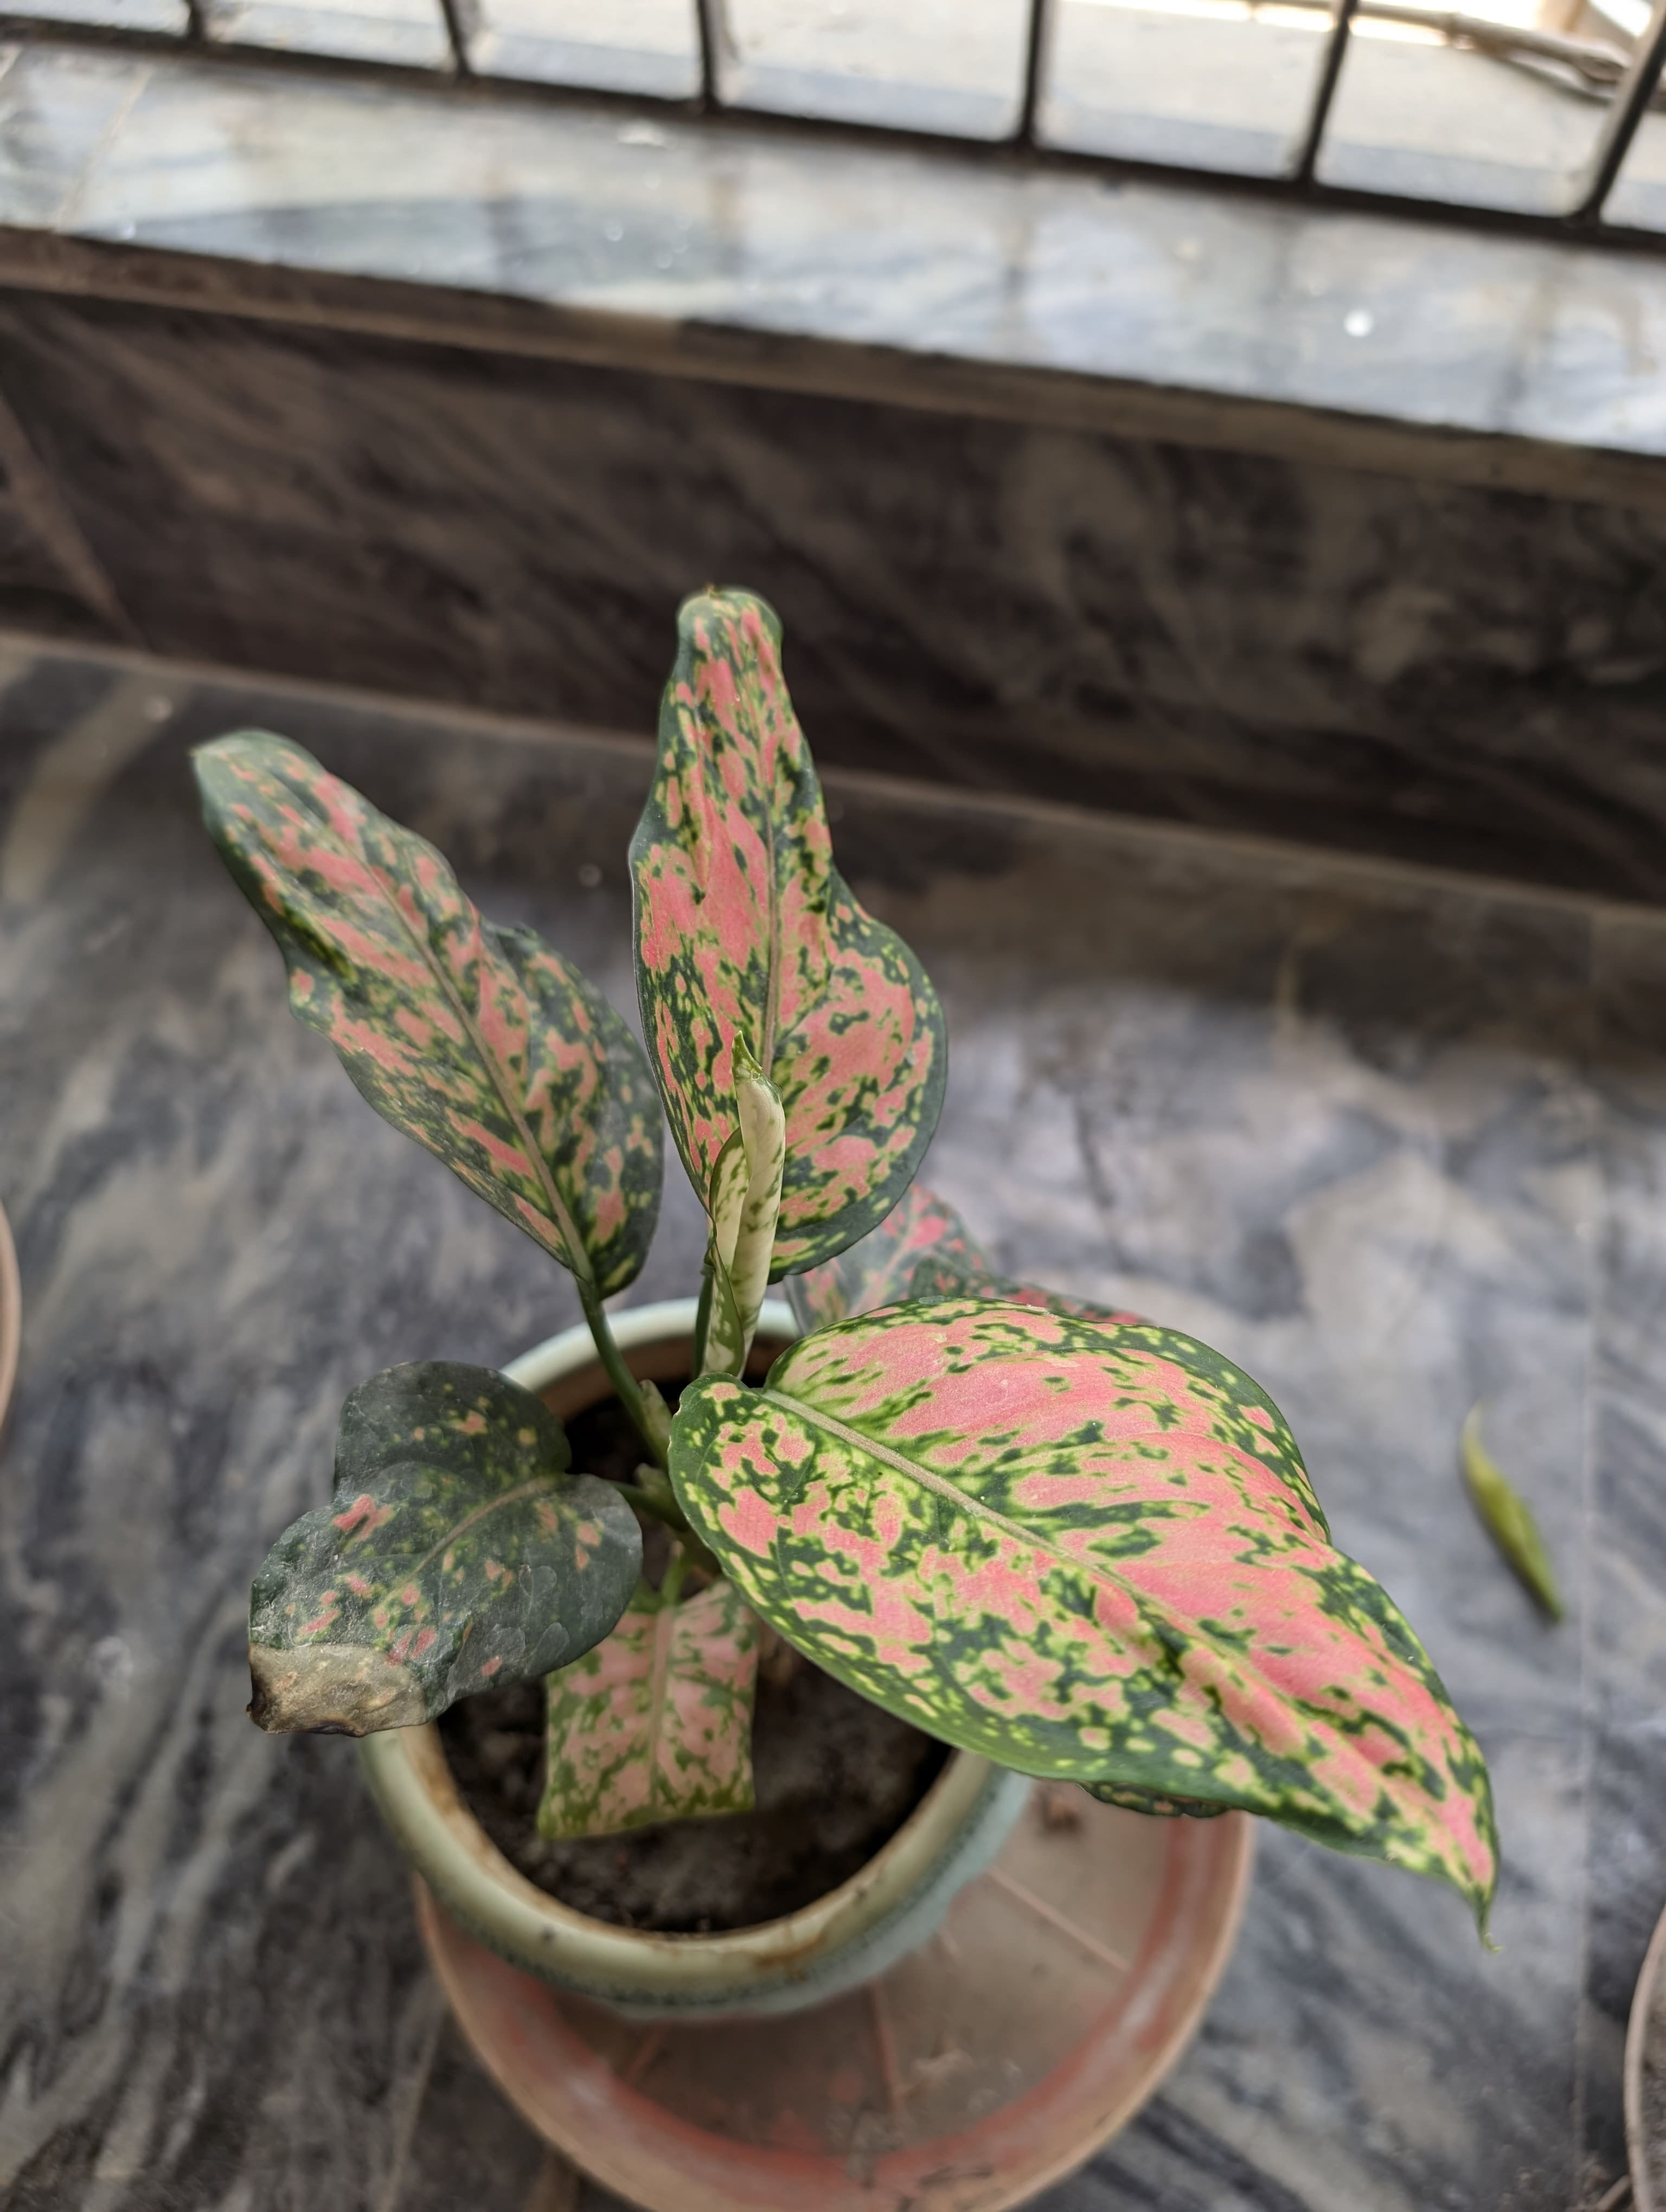

In [ ]:
# inference

from PIL import Image

img = Image.open('/content/houseplant-test-01.jpg')

img


In [ ]:
# prepare image for the model
encoding = image_processor(img.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
import torch

# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: healthy


In [ ]:
# probabilities from the logit function for both the classes
probabilities = torch.softmax(logits, dim=1)
print(probabilities)

tensor([[0.5090, 0.4910]])


In [ ]:
# pipeline API

from transformers import pipeline

pipe = pipeline("image-classification", "bhargob11/vit-base-patch16-224-in21k-finetuned-housplants")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
pipe(img)

[{'label': 'healthy', 'score': 0.5089931488037109},
 {'label': 'wilted', 'score': 0.4910068213939667}]

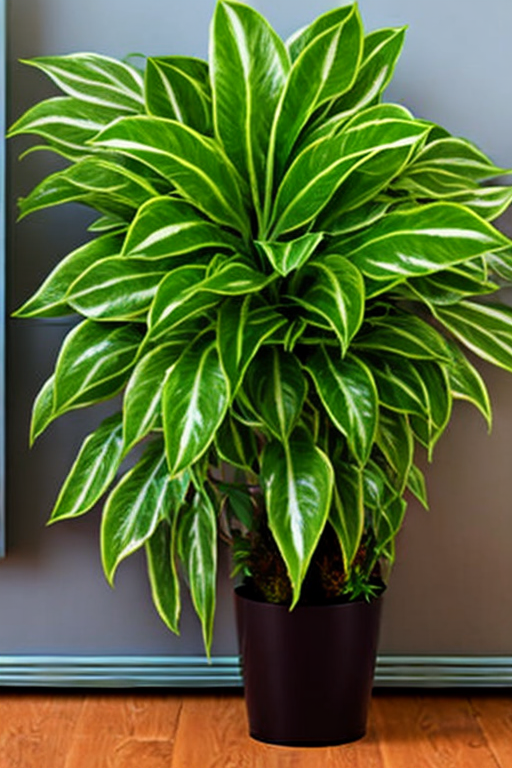

In [ ]:
# Let's try one more healthy image
import requests

image_url = 'https://huggingface.co/datasets/bhargob11/houseplants/resolve/main/houseplant_images/wilted/indoor-houseplants-stylish-trendy-.png'

image = Image.open(requests.get(image_url, stream=True).raw)
image

In [ ]:
pipe(image) # much higher probability score!

[{'label': 'healthy', 'score': 0.8134687542915344},
 {'label': 'wilted', 'score': 0.1865312159061432}]

In [ ]:
# let's try for a wilted one!

image_url = 'https://huggingface.co/datasets/bhargob11/houseplants/resolve/main/houseplant_images/wilted/wilted_016.jpg'

image = Image.open(requests.get(image_url, stream=True).raw)

pipe(image) # much higher probability for wilted

[{'label': 'wilted', 'score': 0.7763980031013489},
 {'label': 'healthy', 'score': 0.22360192239284515}]

In [ ]:
output = pipe(image)
output

[{'label': 'wilted', 'score': 0.7763980031013489},
 {'label': 'healthy', 'score': 0.22360192239284515}]

In [ ]:
labels, scores = [], []
for x in output:
  label = x['label']
  score = x['score']

  labels.append(label)
  scores.append(score)

labels


['wilted', 'healthy']

In [ ]:
max_score = max(scores)

index = scores.index(max_score)

labels[index]

'wilted'

In [ ]:
best_prediction = max(output, key=lambda x: x['score'])
best_label = best_prediction['label']

print(f"Best label: {best_label}")

Best label: wilted


In [ ]:
# install gradio
!pip install -q gradio

In [ ]:
import gradio as gr

def image_classifier(image):
  output = pipe(image)
  best_prediction = max(output, key=lambda x: x['score'])
  best_label = best_prediction['label']

  return best_label

gr.close_all()


demo = gr.Interface(fn=image_classifier,
                    inputs=[gr.Image(label="Upload image", type="pil")],
                    outputs=[gr.Textbox(label="Category")],
                    title="Image Classification with Fine-Tuned ViT Model",
                    description="Classify any houseplant images",
                    allow_flagging="never")
                    # examples=["christmas_dog.jpeg", "bird_flight.jpeg", "cow.jpeg"])

demo.launch(share=True) # server_port=int(os.environ['PORT1'])

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://b64b3d7105e81e2274.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
%%writefile app.py

import gradio as gr
from transformers import pipeline

def image_classifier(image):
  pipe = pipeline("image-classification", "bhargob11/vit-base-patch16-224-in21k-finetuned-housplants")
  output = pipe(image)
  best_prediction = max(output, key=lambda x: x['score'])
  best_label = best_prediction['label']

  return best_label

gr.close_all()


demo = gr.Interface(fn=image_classifier,
                    inputs=[gr.Image(label="Upload image", type="pil")],
                    outputs=[gr.Textbox(label="Category")],
                    title="Image Classification with Fine-Tuned ViT Model",
                    description="Classify any houseplant images",
                    allow_flagging="never")
                    # examples=["christmas_dog.jpeg", "bird_flight.jpeg", "cow.jpeg"])

demo.launch(share=True) # server_port=int(os.environ['PORT1'])

Writing app.py


In [ ]:
%%writefile requirements.txt

transformers
gradio

Writing requirements.txt


In [ ]:
!gradio deploy

model.safetensors:   0% 0.00/343M [00:00<?, ?B/s]
optimizer.pt:   0% 0.00/687M [00:00<?, ?B/s]

rng_state.pth:   0% 0.00/14.2k [00:00<?, ?B/s]


scheduler.pt:   0% 0.00/1.06k [00:00<?, ?B/s]



Upload 29 LFS files:   0% 0/29 [00:00<?, ?it/s]




model.safetensors:   0% 1.56M/343M [00:00<00:26, 12.7MB/s]
scheduler.pt: 100% 1.06k/1.06k [00:00<00:00, 4.14kB/s]
training_args.bin: 100% 5.18k/5.18k [00:00<00:00, 16.3kB/s]
rng_state.pth: 100% 14.2k/14.2k [00:00<00:00, 41.9kB/s]


model.safetensors:   0% 0.00/343M [00:00<?, ?B/s]


optimizer.pt:   0% 0.00/687M [00:00<?, ?B/s]




rng_state.pth:   0% 0.00/14.2k [00:00<?, ?B/s]
optimizer.pt:   0% 2.59M/687M [00:00<03:44, 3.05MB/s]


optimizer.pt:   1% 7.42M/687M [00:00<00:09, 74.2MB/s]

model.safetensors:   0% 1.69M/343M [00:00<00:31, 10.7MB/s]
rng_state.pth: 100% 14.2k/14.2k [00:00<00:00, 51.8kB/s]

optimizer.pt:   1% 6.34M/687M [00:00<01:32, 7.36MB/s]
optimizer.pt:   1% 7.63M/687M [00:01<01:20, 8.43MB/s]


model.safetensors:   2% 6.54M/343M [0